In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
import numpy

In [2]:
data = pd.read_csv("AIDSdata.csv")
# We drop `id` because it's just the identification number of each patient
# We exclude `time_d` and `censor_d` because these seem unfair to include 
#     in modeling since they contain information about time and censor
# We chose not to include `txgrp` and `strat2` because they were derived 
# (and thus highly correlated with) from other predictor variables. 
data = data.drop(['id', 'time_d', 'censor_d', 'txgrp', 'strat2', 'time_d'], axis=1)

In [3]:
data.head(3)

,time,censor,tx,sex,raceth,ivdrug,hemophil,karnof,cd4,priorzdv,age
0,110,0,0,2,3,1,0,90,8.0,9.0,16
1,88,0,0,1,2,1,0,90,37.0,6.0,35
2,256,0,0,1,1,1,0,100,35.0,11.0,29


In [4]:
# We now separate predictors and labels

# predictors
X = data[['tx', 'sex', 'raceth', 'ivdrug', 
          'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']]

# labels
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values.
# source: https://stackoverflow.com/questions/53562813/xgboost-cox-survival-time-entry
censorL = [c for c in data.censor]
timeL = [t for t in data.time]
time_censor = list(zip(censorL, timeL))
y = [x[1] if x[0] else -x[1] for x in time_censor]

In [5]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [7]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, 
                            evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:4.93354
[1000]	test-cox-nloglik:4.26032
[2000]	test-cox-nloglik:4.13145
[3000]	test-cox-nloglik:4.09043
[4000]	test-cox-nloglik:4.07798
[5000]	test-cox-nloglik:4.0808
[6000]	test-cox-nloglik:4.10275
[7000]	test-cox-nloglik:4.12964
[8000]	test-cox-nloglik:4.16702
[9000]	test-cox-nloglik:4.19867
[9999]	test-cox-nloglik:4.23208


In [8]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:6.55763
[1000]	test-cox-nloglik:5.68376
[2000]	test-cox-nloglik:5.39794
[3000]	test-cox-nloglik:5.18218
[4000]	test-cox-nloglik:5.01053
[4999]	test-cox-nloglik:4.85618


In [9]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [10]:
# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8343096234309624

In [11]:
# Explain the Model's Predictions on the Entire Dataset with SHAP values

In [12]:
shap_values = shap.TreeExplainer(model).shap_values(X)

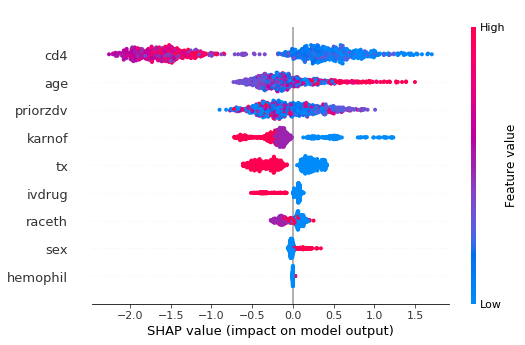

In [13]:
shap.summary_plot(shap_values, X)

In [15]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

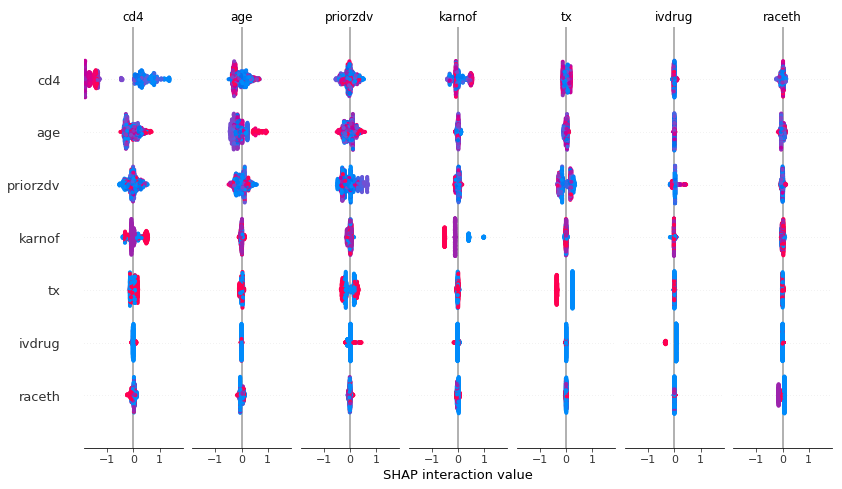

In [16]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

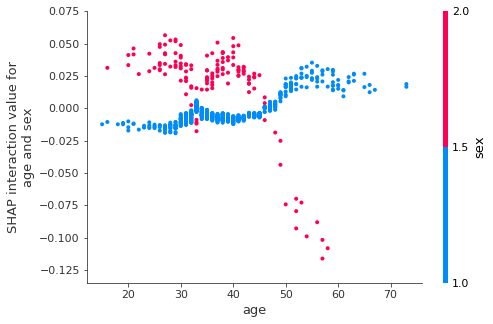

In [18]:
shap.dependence_plot(
    ("age", "sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X.iloc[:2000,:]
)

In [17]:
X_display,y_display = shap.datasets.nhanesi(display=True)

In [21]:
X,y = shap.datasets.nhanesi()

In [23]:
y

array([ 15.27465753,  11.58607306,   8.14908676, ..., -18.87716895,
       -19.68310502,  17.93858447])

In [24]:
from sksurv.datasets import load_aids

ModuleNotFoundError: No module named 'sksurv'

In [32]:
X,y = shap.datasets.nhanesi()

In [12]:
y_test.to_numpy()

array([[ 56],
       [264],
       [284],
       [362],
       [169],
       [242],
       [300],
       [306],
       [250],
       [315],
       [311],
       [ 40],
       [280],
       [273],
       [149],
       [251],
       [313],
       [335],
       [276],
       [276],
       [256],
       [336],
       [132],
       [116],
       [283],
       [150],
       [298],
       [217],
       [315],
       [291],
       [297],
       [138],
       [313],
       [299],
       [224],
       [293],
       [ 55],
       [189],
       [250],
       [305],
       [285],
       [298],
       [104],
       [215],
       [333],
       [277],
       [271],
       [280],
       [326],
       [130],
       [291],
       [313],
       [284],
       [175],
       [348],
       [228],
       [313],
       [245],
       [  2],
       [257],
       [242],
       [315],
       [329],
       [259],
       [257],
       [329],
       [319],
       [335],
       [293],
       [278],
       [264],
      

In [34]:
y

array([ 15.27465753,  11.58607306,   8.14908676, ..., -18.87716895,
       -19.68310502,  17.93858447])